# Preprocessing Data

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
# these two files are large, and it may take a while to read...
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)
print(len(counts))
print(len(weather))

/var/folders/8q/1hs5pwm55k7_wwy4xc5xkd140000gn/T/ipykernel_86855/1276500006.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)


61296
1340


In [30]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

In [31]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [32]:
# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)


(8.0, 17.0)

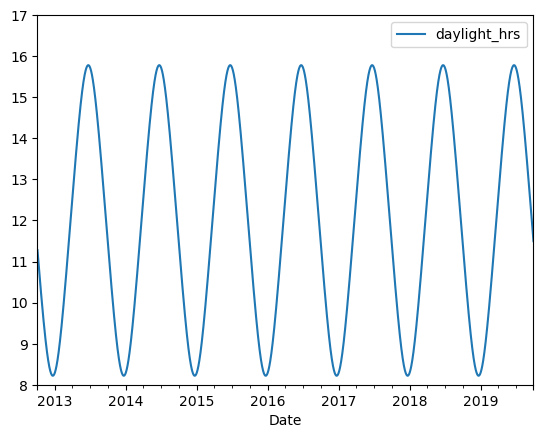

In [33]:
# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.Timestamp(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [34]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], rsuffix='_weather')
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_ri

In [35]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [36]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


# Comparing Models

In [43]:
import numpy as np
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler

# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

# Standardize the features for better regression performance
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create instances of Lasso and Ridge models with default alpha values
linear_reg = LinearRegression()
lasso_reg = Lasso()
ridge_reg = Ridge()

# Define parameter grids for hyperparameter tuning
lasso_param_grid = {'alpha': np.logspace(-3, 3, 100)}  # Adjust the alpha values
ridge_param_grid = {'alpha': np.logspace(-3, 3, 100)}  # Adjust the alpha values

# Create RandomizedSearchCV instances for Lasso and Ridge
lasso_random_search = RandomizedSearchCV(lasso_reg, lasso_param_grid, n_iter=100, cv=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
ridge_random_search = RandomizedSearchCV(ridge_reg, ridge_param_grid, n_iter=100, cv=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Perform hyperparameter tuning with RandomizedSearchCV
lasso_random_search.fit(X, y)
ridge_random_search.fit(X, y)

# Get the best alpha values
best_lasso_alpha = lasso_random_search.best_params_['alpha']
best_ridge_alpha = ridge_random_search.best_params_['alpha']

print(f'Best Lasso Alpha: {best_lasso_alpha}')
print(f'Best Ridge Alpha: {best_ridge_alpha}')

# Create instances of Lasso and Ridge models with the best alpha values
best_lasso_reg = Lasso(alpha=best_lasso_alpha)
best_ridge_reg = Ridge(alpha=best_ridge_alpha)

# Perform 10-fold cross-validation with the best models
lasso_scores = cross_val_score(best_lasso_reg, X, y, cv=10, scoring='neg_mean_squared_error')
ridge_scores = cross_val_score(best_ridge_reg, X, y, cv=10, scoring='neg_mean_squared_error')

# Calculate the mean squared error (MSE) scores and convert them to positive values
lasso_mse = -lasso_scores.mean()
ridge_mse = -ridge_scores.mean()

# Now, let's include Linear Regression in the comparison
linear_scores = cross_val_score(linear_reg, X, y, cv=10, scoring='neg_mean_squared_error')
linear_mse = -linear_scores.mean()

print(f'LinearRegression Score: {linear_mse}')
print(f'Lasso Regression Score: {lasso_mse}')
print(f'Ridge Regression Score: {ridge_mse}')

# Compare the MSE scores to select the best model
best_model = "Linear Regression"  # Initialize with Linear Regression

if lasso_mse <= ridge_mse and lasso_mse <= linear_mse:
    best_model = "Lasso Regression"
elif ridge_mse <= lasso_mse and ridge_mse <= linear_mse:
    best_model = "Ridge Regression"

print("Best model:", best_model)


/Users/zacharycervenka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e+06, tolerance: 1.476e+05
  model = cd_fast.enet_coordinate_descent(
/Users/zacharycervenka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.547e+06, tolerance: 1.544e+05
  model = cd_fast.enet_coordinate_descent(
/Users/zacharycervenka/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Best Lasso Alpha: 7.56463327554629
Best Ridge Alpha: 40.37017258596558
LinearRegression Score: 233675.59438598217
Lasso Regression Score: 233371.92779237698
Ridge Regression Score: 232567.31580303918
Best model: Ridge Regression
